# Optimal Fast Uplink Grant Allocations 

## Importing the libraries

In [1]:
from math import e
from scipy import stats
import math
import operator
import random
import sys
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Python progress bar

In [2]:
def progressbar(it, prefix="", size=60, file=sys.stdout):
    count = len(it)
    def show(j):
        x = int(size*j/count)
        file.write("%s[%s%s] %i/%i\r" % (prefix, "#"*x, "."*(size-x), j, count))
        file.flush()        
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    file.write("\n")
    file.flush()

## MTD Availability (Loading LSTM Output)

In [3]:
real_tx = pd.read_csv('autal_tx.csv')
predicted = pd.read_csv('predicted_tx.csv')

In [4]:
tx = np.array(real_tx)
tx_rate = tx.sum(axis=1)
active_MTDs = pd.DataFrame(tx_rate)
No_active_MTDs = active_MTDs.groupby(0)[0].describe()
No_active_MTDs.to_csv('No_active_MTDs.csv', index=False)
No_active_MTDs = np.array(No_active_MTDs)

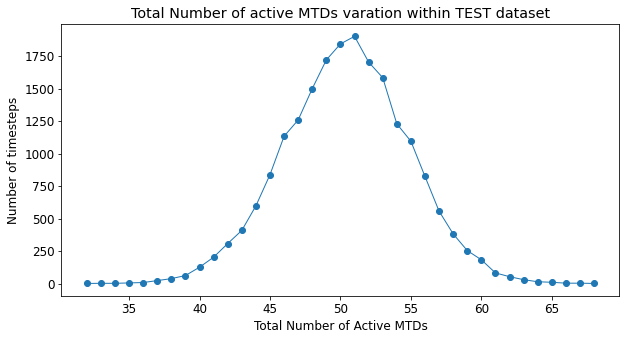

In [5]:
plt.rcParams['figure.figsize']=(10,5) 
font ={'size':12} 
plt.rc('font',**font) 
plt.plot(No_active_MTDs[:,1],No_active_MTDs[:,0] ,'o-',lw=1) 
plt.title('Total Number of active MTDs varation within TEST dataset') 
plt.ylabel('Number of timesteps') 
plt.xlabel('Total Number of Active MTDs') 
plt.show()

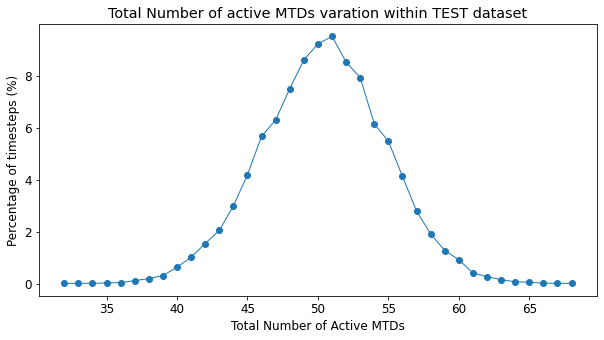

In [6]:
plt.rcParams['figure.figsize']=(10,5) 
font ={'size':12} 
plt.rc('font',**font) 
plt.plot(No_active_MTDs[:,1],(No_active_MTDs[:,0]/19990)*100 ,'o-',lw=1) 
plt.title('Total Number of active MTDs varation within TEST dataset') 
plt.ylabel('Percentage of timesteps (%)') 
plt.xlabel('Total Number of Active MTDs') 
plt.show()

## MTD Latency Requirements

In [7]:
delay =[]
for i in range(1,101):
    d = [i,random.randint(100,200)]
    delay.append(d)
delay = np.array(delay)

In [8]:
MTD_latency = pd.DataFrame(delay)
MTD_latency = MTD_latency.groupby(1)[1].describe()
MTD_latency.to_csv('MTD_latency.csv', index=False)
MTD_latency = np.array(MTD_latency)

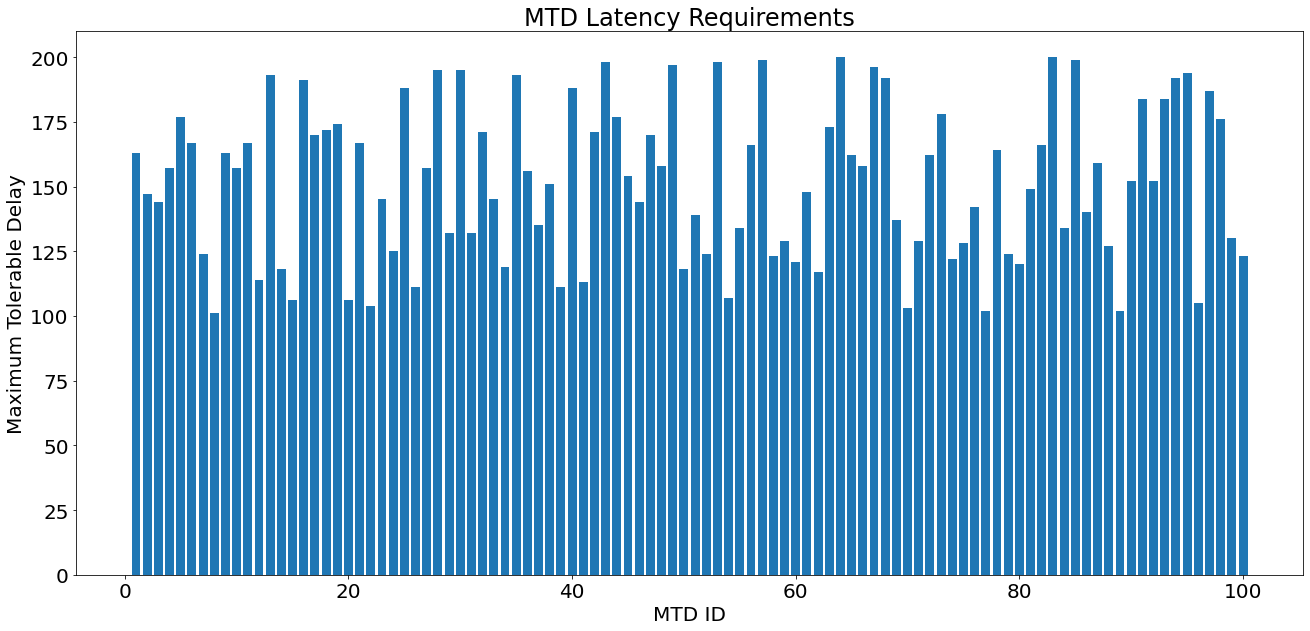

In [9]:
# change the font size on a matplotlib plot 
font = {'size' : 20} 
plt.rc('font', **font)
# change the graph size of a matplotlib plot 
plt.rcParams['figure.figsize'] = (22, 10)


# Visualising the results for UCB
plt.bar(delay[:,0],delay[:,1])
plt.title('MTD Latency Requirements')
plt.xlabel('MTD ID')
plt.ylabel('Maximum Tolerable Delay')
plt.show()

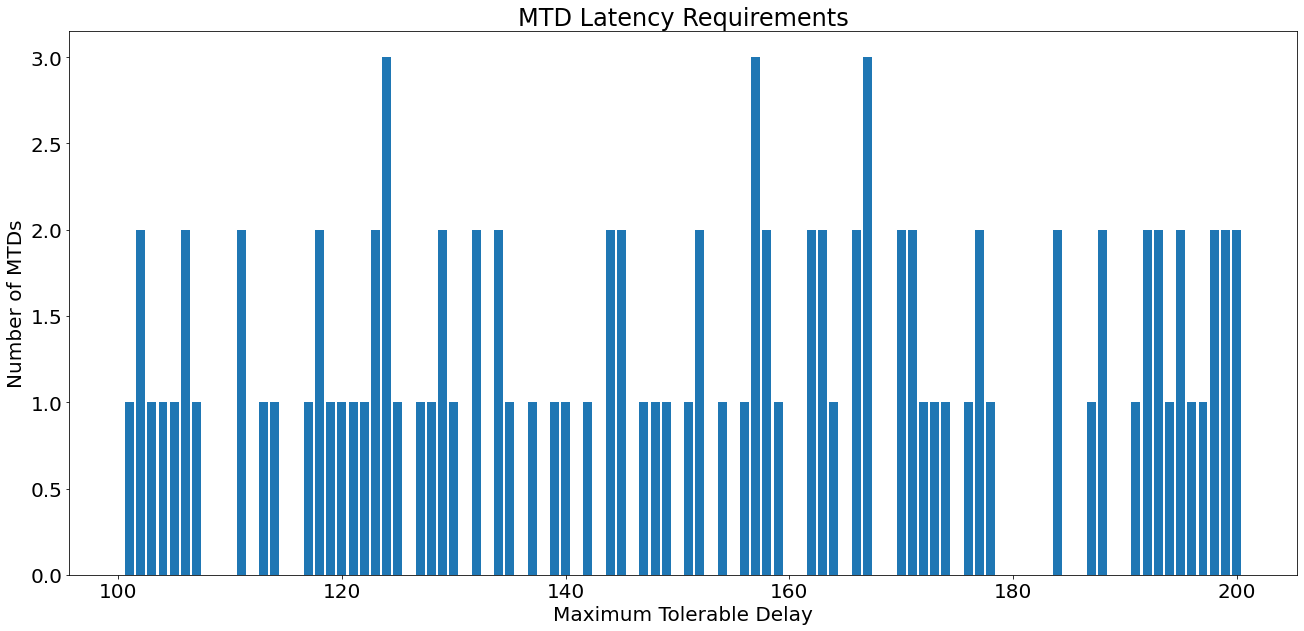

In [10]:
# change the font size on a matplotlib plot 
font = {'size' : 20} 
plt.rc('font', **font)
# change the graph size of a matplotlib plot 
plt.rcParams['figure.figsize'] = (22, 10)


# Visualising the results for UCB
plt.bar(MTD_latency[:,1],MTD_latency[:,0])
plt.title('MTD Latency Requirements')
plt.xlabel('Maximum Tolerable Delay')
plt.ylabel('Number of MTDs')
plt.show()

## MTD Latency based Reward Function
Apply modified gompertz function for modeling the Maximum tolerable delay of the data packets. Selecting a,b and c parameters of modified gompertz function to match with the maximum tolerable delay values of the network (better to select function values distribute equally between 0 and 1)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


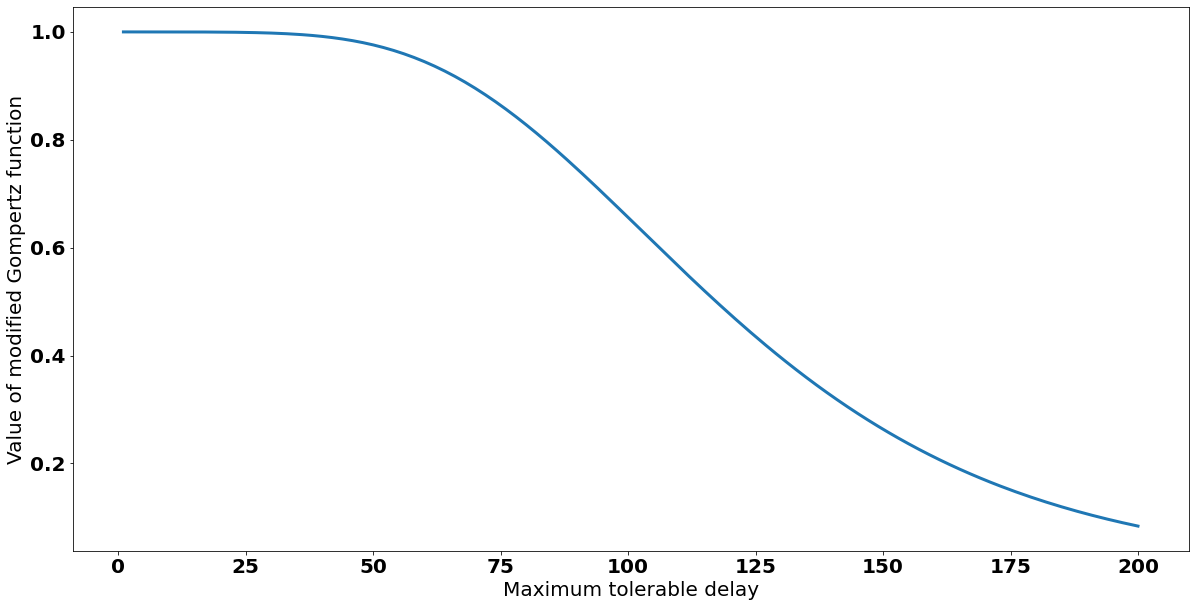

In [11]:
time = np.array(range(1,201))
# Select a, b and c parameters for modified gompertz function
a=1
b=13
c=0.025
modified_gompertz_function = a-a*e**(-b*e**(-c*(time)))

# change the font siXe on a matplotlib plot 
font = {'family' : 'normal','weight' : 'bold','size' : 20} 
plt.rc('font', **font)
# change the graph siXe of a matplotlib plot 
plt.rcParams['figure.figsize'] = (20, 10)

plt.plot(time, modified_gompertz_function, lw = 3) # 'r' is the color red
plt.xlabel('Maximum tolerable delay')
plt.ylabel('Value of modified Gompertz function')
plt.show()

## Implement Probablistic multi armed bandit allocation policy with LSTM predictions

In [12]:
a=1
b=13
c=0.025
s=10
TS = 19990
MTD = 100
number_of_channels = 5
###############################################
MTD_selected_UCB = []
tolerable_delay_of_selected_mtd = []
numbers_of_selections = [0] * MTD
sums_of_rewards = [0] * MTD
total_reward = 0
best_reward = 0
real_reward_probabilitic = []
imaginary_reward = []
active_MTDs = np.empty((0,5))
################################################

for n in progressbar(range(0,TS)):
    
    packet_list = []
    reward_list = []
    upper_bound_array = []
    mtd_list = []
    probability_list = []
    upper_bound_array = np.empty((0,2))
    packet_q = np.empty((0,5))
    
    for i in range(0,MTD):
        
        pi_t = predicted.values[n, i]
        
        # getting active MTD list
        if pi_t >= 0.5:
            Di_t = delay[i][1]
            Ri_t = a-a*e**(-b*e**(-c*(Di_t)))
            active_mtd = np.array([n,i,pi_t,Di_t,Ri_t])
            active_MTDs = np.vstack([active_MTDs, active_mtd])
            # getting the packet list of MTD i
            ##################################
            packet_mtd_i = np.where(active_MTDs[:,1] == i)
            # getting the packet with lowest delay for MTD i
            ################################################
            packet = packet_mtd_i[0][0]
            packet_list.append(packet)
            
            # getting the list of packet with lowest delay
            #########################################################
            packet_mtd_i = active_MTDs[packet]
            packet_q = np.vstack([packet_q,packet_mtd_i])
            
            # getting the probability of the packet with lowest delay
            ##############################################
            P = active_MTDs[packet,2]
            probability_list.append(P)
            # getting the mtd it of the packet with lowest delay
            ####################################################
            mtd_id = active_MTDs[packet,1]
            mtd_list.append(mtd_id)
            # getting the reward of the packet with lowest delay
            ####################################################
            R = active_MTDs[packet,4]
            reward_list.append(R)
            
            # calculating UCB values
            ##########################################
            if (numbers_of_selections[i] > 0):
                average_reward = sums_of_rewards[i] / numbers_of_selections[i]
                delta_i = math.sqrt(s * math.log(n + 1) / numbers_of_selections[i])
                upper_bound = (average_reward + delta_i)*P
            else:
                upper_bound = 1e400
            upper_bound_mtd_i = np.array([i,upper_bound])
            upper_bound_array = np.vstack([upper_bound_array,upper_bound_mtd_i])
            
            # sort UCB values to accending order  
            ###############################################################
            sorted_upper_bound = upper_bound_array[upper_bound_array[:,1].argsort()[::-1]]
            highest_upper_bound_MTDs = sorted_upper_bound[0:number_of_channels:1,0].astype(int)
        
    selected_mtds_of_timestep = []
    tolerable_delay_of_selected_mtd_of_timestep = []
    
    # selected MTD loop
    for t in highest_upper_bound_MTDs:
        reward = packet_q[np.where(packet_q[:,1] == t)[0][0],4]
        tolerable_delay = packet_q[np.where(packet_q[:,1] == t)[0][0],3]
        # get the sum of reward for each selected MTD
        sums_of_rewards[t] = sums_of_rewards[t] + reward
        # get the total reward after every selection
        total_reward = total_reward + reward
        # increment number of selection by one
        numbers_of_selections[t] += 1
        # append selected MTD list
        selected_mtds_of_timestep.append(t)
        tolerable_delay_of_selected_mtd_of_timestep.append(tolerable_delay)
    
    # Per time  step assignments
    real_reward_probabilitic.append(total_reward)
    MTD_selected_UCB.append(selected_mtds_of_timestep)
    tolerable_delay_of_selected_mtd.append(tolerable_delay_of_selected_mtd_of_timestep)
    
    # Calculating the maximum rewards of the time step
    Maximum_rewards = active_MTDs[active_MTDs[:,4].argsort()[::-1]][1:number_of_channels:1,4]
    for max_reward in Maximum_rewards:
        best_reward = best_reward + max_reward
    imaginary_reward.append(best_reward)
    
    # delay and reward update for active_MTDs
    #########################################
    for i in range(0,len(active_MTDs)):
        active_MTDs[i,3] = active_MTDs[i,3]-1
        active_MTDs[i,4] = a-a*e**(-b*e**(-c*(active_MTDs[i,3])))
        
    # removing experied packets from the active mtd list
    ####################################################
    active_MTDs = np.delete(active_MTDs, (np.where(active_MTDs[:,3] == 0)), axis=0)
    
    # removing selected packets from the active mtd list
    ####################################################
    for m in range(0,len(selected_mtds_of_timestep)):
        K = selected_mtds_of_timestep[m]
        active_MTDs = np.delete(active_MTDs, (np.where(active_MTDs[:,1] == K)), axis=0)

[############################################################] 19990/19990


## Packet Queuing Mechanism

In [13]:
columns = ["Timesteps index [n]","MTD index [i]","Probability of being Active [Pi(t)]","Tolerable delay [Di(t)]","Reward [Ri(t)]"]
MTD_Queue = pd.DataFrame(active_MTDs,columns=columns)
MTD_Queue

,Timesteps index [n],MTD index [i],Probability of being Active [Pi(t)],Tolerable delay [Di(t)],Reward [Ri(t)]
0,19827.0,63.0,1.0,37.0,0.994229
1,19829.0,63.0,1.0,39.0,0.992579
2,19830.0,63.0,1.0,40.0,0.991624
3,19833.0,63.0,1.0,43.0,0.988167
4,19836.0,63.0,1.0,46.0,0.983695
...,...,...,...,...,...
1240,19989.0,83.0,1.0,133.0,0.373523
1241,19989.0,89.0,1.0,151.0,0.257834
1242,19989.0,92.0,1.0,183.0,0.125394
1243,19989.0,97.0,1.0,175.0,0.150957


# Analysing the results and evaluating the performance of the proposed method
Imaginary reward is the maximum reward that possible to acheive by selection MTDs for channel allocation in the most optimal as possible. 

Read reward is the reward that we can obtain by applying proposed probabilistic sleeping MAB with UCB algorithm.

## Reward and regret analysis

These numpy array contain the cumulative value of the reward and regret for each time step that algorithm was run.

In [14]:
# Create Numpy array that contain highest possible reward over time
imaginary_reward = np.array(imaginary_reward)
# Create Numpy array that contain reward over time for proposed probablitic sleeping MAB algorithm
real_reward_probabilitic = np.asarray(real_reward_probabilitic)
# Create Numpy array that contain regert of proposed probablitic sleeping algorithm over time
regert_probabilitic_prediction = imaginary_reward - real_reward_probabilitic

## Visualizing number of times each MTD was selected by above algorithm (Multiple Selection)



findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


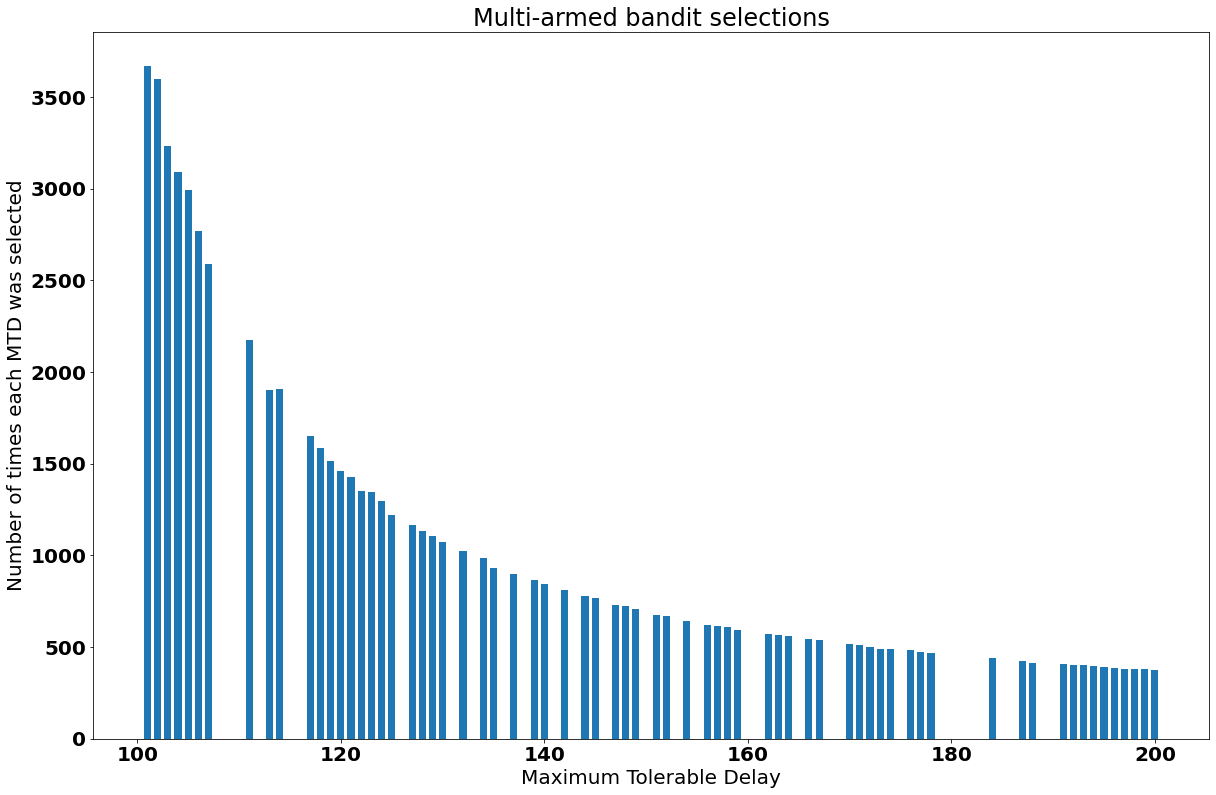

In [15]:
# create a MTD id array 
MTD_id = np.array(range(1,MTD+1))
# create a selected MTD array
numbers_of_selections = np.asarray(numbers_of_selections)

MTD_selections = [MTD_id,delay[:,1],numbers_of_selections]
MTD_selections = np.array(MTD_selections)
MTD_selections = np.transpose(MTD_selections)
MTD_selections = pd.DataFrame(MTD_selections)
MTD_selections.to_csv('MTD_selections.csv', index=False)

# change the font siXe on a matplotlib plot 
font = {'family' : 'normal','weight' : 'bold','size' : 20} 
plt.rc('font', **font)
# change the graph siXe of a matplotlib plot 
plt.rcParams['figure.figsize'] = (20, 13)

# Visualising the results for UCB
plt.bar(delay[:,1],numbers_of_selections,width=0.7)
plt.title('Multi-armed bandit selections')
plt.xlabel('Maximum Tolerable Delay')
plt.ylabel('Number of times each MTD was selected')
plt.show()

## Create numpy array that contain selected MTDs by proposed sleeping MAB+UCB algorithm over time

This tolerable_delay_of_selected_MTD array contain the tolerbale delay when a MTDs is selected. Since after MTD activation delay is degraded with time this tolerbale delay of a selected MTDs could be less that its fixed maximum tolerble delay value.

In [16]:
MTD_selected_UCB = np.asarray(MTD_selected_UCB)
MTD_selected_UCB = np.reshape(MTD_selected_UCB, (-1,1))
tolerable_delay_of_selected_mtd = np.asarray(tolerable_delay_of_selected_mtd)
tolerable_delay_of_selected_mtd = np.reshape(tolerable_delay_of_selected_mtd, (-1,1))

## Create a numpy array to repesent multiple selections at each time step

In [17]:
Time = np.array(range(0,TS))
Time = np.reshape(Time, (TS, 1))
#contTime = np.concatenate((Time, Time, Time, Time, Time,Time, Time, Time, 
#                           Time, Time,Time, Time, Time, Time, Time, Time, 
#                           Time, Time, Time, Time,Time), axis=1)
contTime = np.concatenate((Time, Time, Time, Time, Time), axis=1)
contTime = np.reshape(contTime, (-1,1))
contTime.shape

(99950, 1)

## Create numpy array that contain maximum tolerable delay of each MTD of the network

X numpy array conatin the maximum tolerable delay of each MTD in the network

In [18]:
delay_array = np.array(delay)

## Create numpy array that contain maximum tolerabel delay of selected MTDs by the algorithm over time

In [19]:
MTD_selected_UCB_X = delay_array[MTD_selected_UCB]
Maximum_Tolerable_Delay_of_selected_MTDs = [contTime,MTD_selected_UCB_X[:,:,1]]
Maximum_Tolerable_Delay_of_selected_MTDs = np.array(Maximum_Tolerable_Delay_of_selected_MTDs)
Maximum_Tolerable_Delay_of_selected_MTDs = Maximum_Tolerable_Delay_of_selected_MTDs.reshape(2,-1)
Maximum_Tolerable_Delay_of_selected_MTDs = pd.DataFrame(Maximum_Tolerable_Delay_of_selected_MTDs)
Maximum_Tolerable_Delay_of_selected_MTDs.to_csv('Maximum_Tolerable_Delay_of_selected_MTDs.csv', index=False)

In [20]:
MTD_selected_UCB_X.shape

(99950, 1, 2)

## Visualizing the maximum tolerable delay of the selected MTDs by algorithm over the time

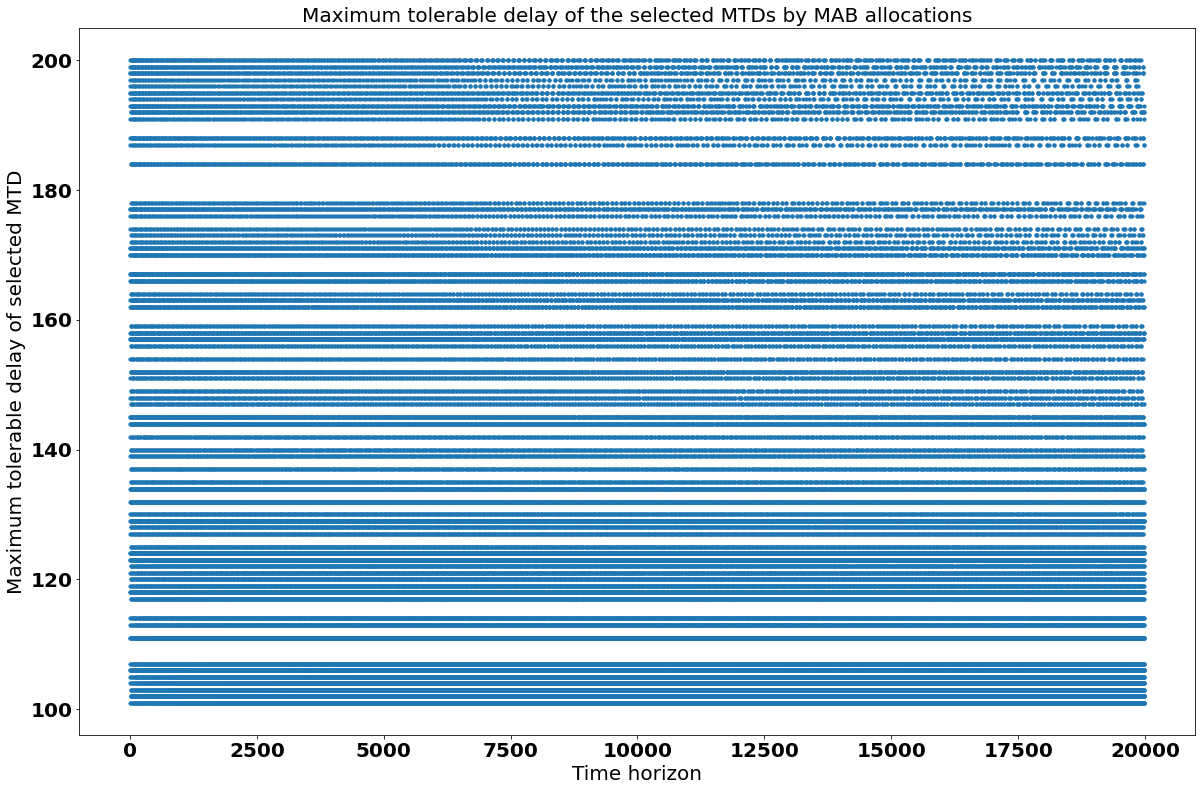

In [21]:
# change the font siXe on a matplotlib plot 
font = {'family' : 'normal','weight' : 'bold','size' : 20} 
plt.rc('font', **font)
# change the graph siXe of a matplotlib plot 
plt.rcParams['figure.figsize'] = (20, 13)

# Visualising the maximum tolerable delay of the selected MTDs by algorithm over the time
plt.scatter(contTime,MTD_selected_UCB_X[:,:,1],s=10)
plt.title('Maximum tolerable delay of the selected MTDs by MAB allocations',fontsize=20)
plt.xlabel('Time horizon',fontsize=20)
plt.ylabel('Maximum tolerable delay of selected MTD',fontsize=20)
plt.show()

In [22]:
# Reshape the MTD_selected_UCB_X array
MTD_selected_UCB_X = np.reshape(MTD_selected_UCB_X[:,:,1], (TS*number_of_channels, ))
tolerable_delay_of_selected_mtd = np.reshape(tolerable_delay_of_selected_mtd, (TS*number_of_channels, ))
MTD_selected_UCB_X.shape

(99950,)

In [23]:
tolerable_delay_of_selected_mtd.shape

(99950,)

## Create numpy array that contain achived access delay of selected MTDs by the algorithm over time

Achived access delay represent the amount of time that MTD has to wait after its activation until it selected by the algorithm.

In [24]:
achieved_access_delay = MTD_selected_UCB_X - tolerable_delay_of_selected_mtd
achieved_access_delay

array([ 0.,  0.,  0., ..., 34.,  0.,  6.])

In [25]:
MTD_selected_UCB_X = np.reshape(MTD_selected_UCB_X, (TS*number_of_channels, ))
tolerable_delay_of_selected_mtd = np.reshape(tolerable_delay_of_selected_mtd, (TS*number_of_channels, ))
achieved_access_delay = np.reshape(achieved_access_delay, (TS*number_of_channels, ))

In [26]:
delays_of_selected_MTDs = pd.DataFrame({'Maximum tolerable Delay':MTD_selected_UCB_X,'Tolerable Delay':tolerable_delay_of_selected_mtd, 'Achieved Access Delay':achieved_access_delay})
delays_of_selected_MTDs

,Maximum tolerable Delay,Tolerable Delay,Achieved Access Delay
0,176,176.0,0.0
1,187,187.0,0.0
2,124,124.0,0.0
3,197,197.0,0.0
4,158,158.0,0.0
...,...,...,...
99945,129,129.0,0.0
99946,124,94.0,30.0
99947,125,91.0,34.0
99948,101,101.0,0.0


In [27]:
Maximum_Tolerbale_delay = delays_of_selected_MTDs.iloc[:,0].unique()
Maximum_Tolerbale_delay[::1].sort()

In [28]:
A = Maximum_Tolerbale_delay.tolist()
len(A)

68

## Calculate the average value of achieved access delay

In [29]:
average_achieved_delay_probabilitic = delays_of_selected_MTDs.groupby("Maximum tolerable Delay")['Achieved Access Delay'].describe()
average_achieved_delay_probabilitic = np.array(average_achieved_delay_probabilitic)
average_achieved_delay_probabilitic[:,1]

array([ 2.96676655,  3.68807082,  3.79480841,  4.36275461,  5.03938585,
        5.09778429,  5.53804558,  7.45932125,  7.98161765,  9.02042954,
       10.11764706, 10.37044146, 10.96308504, 11.39931507, 12.05886475,
       12.20962963, 13.05549306, 13.42210663, 13.62540984, 14.89545844,
       15.38678414, 15.87482993, 16.39794967, 17.51902439, 18.62653061,
       18.69709989, 19.95782464, 21.14532872, 21.56670602, 22.600246  ,
       23.44789644, 24.11045752, 24.87225275, 25.69793103, 26.15112994,
       26.88888889, 27.45952024, 28.50310559, 29.55144695, 29.97345612,
       30.78671042, 31.20637584, 32.48681898, 33.16799293, 33.5875    ,
       34.710988  , 35.27853598, 36.87949466, 37.22758621, 37.636     ,
       37.93292683, 38.85132383, 39.55809129, 39.95202559, 40.76873662,
       43.76632302, 45.04941176, 45.60336538, 47.1773399 , 47.25465839,
       48.12781955, 48.76262626, 48.92611465, 49.11168831, 49.71052632,
       50.20549738, 50.73844122, 50.91420912])

## Implement Probablistic multi armed bandit allocation policy with perfect predictions

In [48]:
a=1
b=13
c=0.025
s=5
TS = 19990
MTD = 100
number_of_channels = 5
###############################################
MTD_selected_UCB = []
tolerable_delay_of_selected_mtd = []
numbers_of_selections = [0] * MTD
sums_of_rewards = [0] * MTD
total_reward = 0
best_reward = 0
real_reward_probabilitic = []
imaginary_reward = []
active_MTDs = np.empty((0,5))
################################################

for n in progressbar(range(0,TS)):
    
    packet_list = []
    reward_list = []
    upper_bound_array = []
    mtd_list = []
    probability_list = []
    upper_bound_array = np.empty((0,2))
    packet_q = np.empty((0,5))
    
    for i in range(0,MTD):
        
        pi_t = predicted.values[n, i]
        
        # getting active MTD list
        if pi_t >= 0.5:
            Di_t = delay[i][1]
            Ri_t = a-a*e**(-b*e**(-c*(Di_t)))
            active_mtd = np.array([n,i,pi_t,Di_t,Ri_t])
            active_MTDs = np.vstack([active_MTDs, active_mtd])
            # getting the packet list of MTD i
            ##################################
            packet_mtd_i = np.where(active_MTDs[:,1] == i)
            # getting the packet with lowest delay for MTD i
            ################################################
            packet = packet_mtd_i[0][0]
            packet_list.append(packet)
            
            # getting the list of packet with lowest delay
            #########################################################
            packet_mtd_i = active_MTDs[packet]
            packet_q = np.vstack([packet_q,packet_mtd_i])
            
            # getting the probability of the packet with lowest delay
            ##############################################
            P = active_MTDs[packet,2]
            probability_list.append(P)
            # getting the mtd it of the packet with lowest delay
            ####################################################
            mtd_id = active_MTDs[packet,1]
            mtd_list.append(mtd_id)
            # getting the reward of the packet with lowest delay
            ####################################################
            R = active_MTDs[packet,4]
            reward_list.append(R)
            
            # calculating UCB values
            ##########################################
            if (numbers_of_selections[i] > 0):
                average_reward = sums_of_rewards[i] / numbers_of_selections[i]
                delta_i = math.sqrt(s * math.log(n + 1) / numbers_of_selections[i])
                upper_bound = (average_reward + delta_i)
            else:
                upper_bound = 1e400
            upper_bound_mtd_i = np.array([i,upper_bound])
            upper_bound_array = np.vstack([upper_bound_array,upper_bound_mtd_i])
            
            # sort UCB values to accending order  
            ###############################################################
            sorted_upper_bound = upper_bound_array[upper_bound_array[:,1].argsort()[::-1]]
            highest_upper_bound_MTDs = sorted_upper_bound[0:number_of_channels:1,0].astype(int)
        
    selected_mtds_of_timestep = []
    tolerable_delay_of_selected_mtd_of_timestep = []
    
    # selected MTD loop
    for t in highest_upper_bound_MTDs:
        reward = packet_q[np.where(packet_q[:,1] == t)[0][0],4]
        tolerable_delay = packet_q[np.where(packet_q[:,1] == t)[0][0],3]
        # get the sum of reward for each selected MTD
        sums_of_rewards[t] = sums_of_rewards[t] + reward
        # get the total reward after every selection
        total_reward = total_reward + reward
        # increment number of selection by one
        numbers_of_selections[t] += 1
        # append selected MTD list
        selected_mtds_of_timestep.append(t)
        tolerable_delay_of_selected_mtd_of_timestep.append(tolerable_delay)
    
    # Per time  step assignments
    real_reward_probabilitic.append(total_reward)
    MTD_selected_UCB.append(selected_mtds_of_timestep)
    tolerable_delay_of_selected_mtd.append(tolerable_delay_of_selected_mtd_of_timestep)
    
    # Calculating the maximum rewards of the time step
    Maximum_rewards = active_MTDs[active_MTDs[:,4].argsort()[::-1]][1:number_of_channels:1,4]
    for max_reward in Maximum_rewards:
        best_reward = best_reward + max_reward
    imaginary_reward.append(best_reward)
    
    # delay and reward update for active_MTDs
    #########################################
    for i in range(0,len(active_MTDs)):
        active_MTDs[i,3] = active_MTDs[i,3]-1
        active_MTDs[i,4] = a-a*e**(-b*e**(-c*(active_MTDs[i,3])))
        
    # removing experied packets from the active mtd list
    ####################################################
    active_MTDs = np.delete(active_MTDs, (np.where(active_MTDs[:,3] == 0)), axis=0)
    
    # removing selected packets from the active mtd list
    ####################################################
    for m in range(0,len(selected_mtds_of_timestep)):
        K = selected_mtds_of_timestep[m]
        active_MTDs = np.delete(active_MTDs, (np.where(active_MTDs[:,1] == K)), axis=0)

[############################################################] 19990/19990


In [49]:
# Create Numpy array that contain highest possible reward over time
imaginary_reward = np.array(imaginary_reward)
# Create Numpy array that contain reward over time for proposed probablitic sleeping MAB algorithm
real_reward_probabilitic_perfect = np.asarray(real_reward_probabilitic)
# Create Numpy array that contain regert of proposed probablitic sleeping algorithm over time
regert_probabilitic_prediction_perfect = imaginary_reward - real_reward_probabilitic_perfect

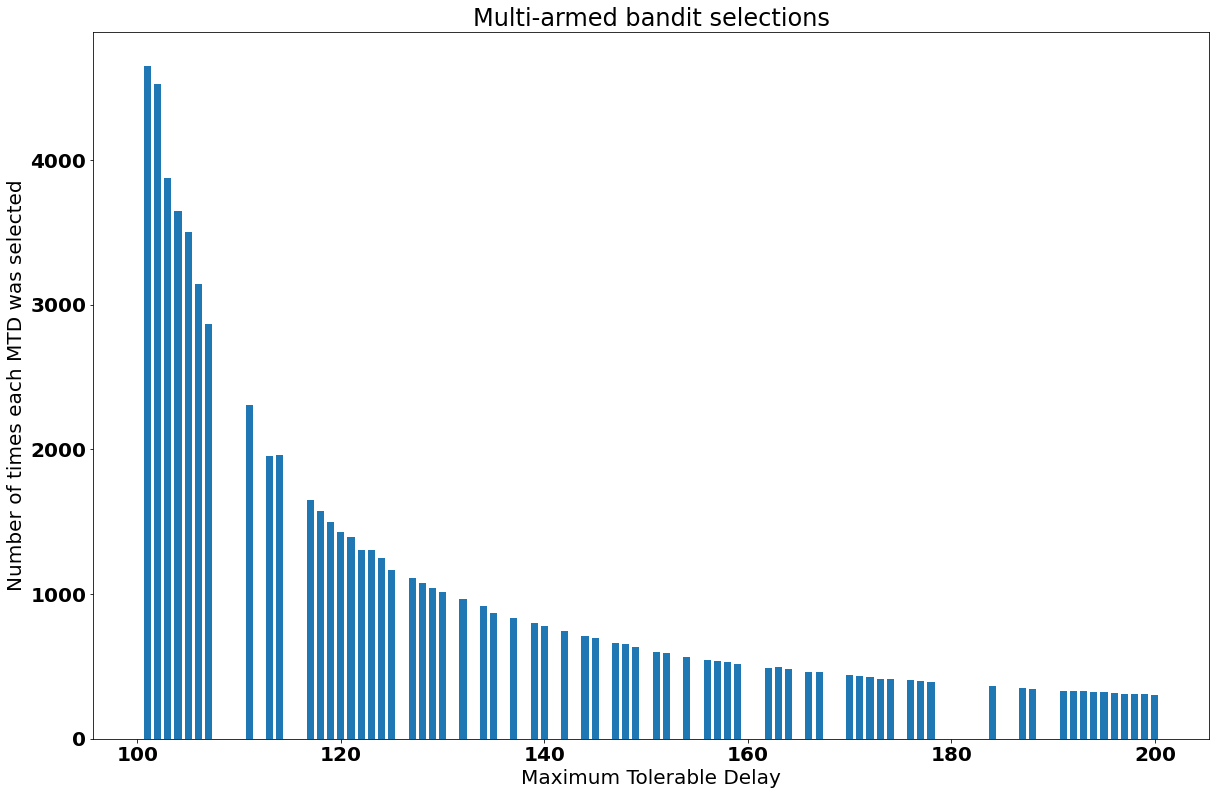

In [50]:
# create a MTD id array 
MTD_id = np.array(range(1,MTD+1))
# create a selected MTD array
numbers_of_selections = np.asarray(numbers_of_selections)

MTD_selections = [MTD_id,delay[:,1],numbers_of_selections]
MTD_selections = np.array(MTD_selections)
MTD_selections = np.transpose(MTD_selections)
MTD_selections = pd.DataFrame(MTD_selections)
MTD_selections.to_csv('MTD_selections.csv', index=False)

# change the font siXe on a matplotlib plot 
font = {'family' : 'normal','weight' : 'bold','size' : 20} 
plt.rc('font', **font)
# change the graph siXe of a matplotlib plot 
plt.rcParams['figure.figsize'] = (20, 13)

# Visualising the results for UCB
plt.bar(delay[:,1],numbers_of_selections,width=0.7)
plt.title('Multi-armed bandit selections')
plt.xlabel('Maximum Tolerable Delay')
plt.ylabel('Number of times each MTD was selected')
plt.show()

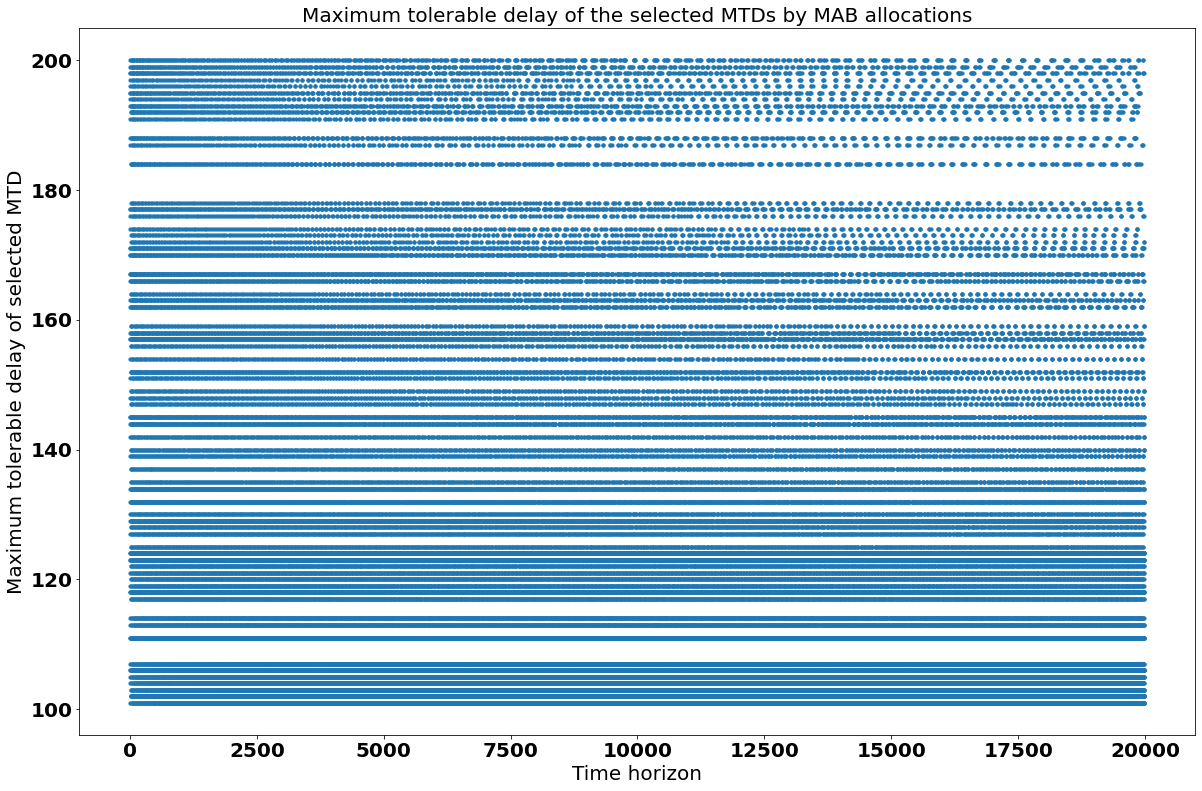

In [51]:
MTD_selected_UCB = np.asarray(MTD_selected_UCB)
MTD_selected_UCB = np.reshape(MTD_selected_UCB, (-1,1))
tolerable_delay_of_selected_mtd = np.asarray(tolerable_delay_of_selected_mtd)
tolerable_delay_of_selected_mtd = np.reshape(tolerable_delay_of_selected_mtd, (-1,1))

Time = np.array(range(0,TS))
Time = np.reshape(Time, (TS, 1))
#contTime = np.concatenate((Time, Time, Time, Time, Time,Time, Time, Time, 
#                           Time, Time,Time, Time, Time, Time, Time, Time, 
#                           Time, Time, Time, Time,Time), axis=1)
contTime = np.concatenate((Time, Time, Time, Time, Time), axis=1)
contTime = np.reshape(contTime, (-1,1))

delay_array = np.array(delay)

MTD_selected_UCB_X = delay_array[MTD_selected_UCB]
Maximum_Tolerable_Delay_of_selected_MTDs = [contTime,MTD_selected_UCB_X[:,:,1]]
Maximum_Tolerable_Delay_of_selected_MTDs = np.array(Maximum_Tolerable_Delay_of_selected_MTDs)
Maximum_Tolerable_Delay_of_selected_MTDs = Maximum_Tolerable_Delay_of_selected_MTDs.reshape(2,-1)
Maximum_Tolerable_Delay_of_selected_MTDs = pd.DataFrame(Maximum_Tolerable_Delay_of_selected_MTDs)
Maximum_Tolerable_Delay_of_selected_MTDs.to_csv('Maximum_Tolerable_Delay_of_selected_MTDs.csv', index=False)


# change the font siXe on a matplotlib plot 
font = {'family' : 'normal','weight' : 'bold','size' : 20} 
plt.rc('font', **font)
# change the graph siXe of a matplotlib plot 
plt.rcParams['figure.figsize'] = (20, 13)

# Visualising the maximum tolerable delay of the selected MTDs by algorithm over the time
plt.scatter(contTime,MTD_selected_UCB_X[:,:,1],s=10)
plt.title('Maximum tolerable delay of the selected MTDs by MAB allocations',fontsize=20)
plt.xlabel('Time horizon',fontsize=20)
plt.ylabel('Maximum tolerable delay of selected MTD',fontsize=20)
plt.show()

In [52]:
# Reshape the MTD_selected_UCB_X array
MTD_selected_UCB_X = np.reshape(MTD_selected_UCB_X[:,:,1], (TS*number_of_channels, ))
tolerable_delay_of_selected_mtd = np.reshape(tolerable_delay_of_selected_mtd, (TS*number_of_channels, ))


achieved_access_delay = MTD_selected_UCB_X - tolerable_delay_of_selected_mtd


MTD_selected_UCB_X = np.reshape(MTD_selected_UCB_X, (TS*number_of_channels, ))
tolerable_delay_of_selected_mtd = np.reshape(tolerable_delay_of_selected_mtd, (TS*number_of_channels, ))
achieved_access_delay = np.reshape(achieved_access_delay, (TS*number_of_channels, ))

delays_of_selected_MTDs = pd.DataFrame({'Maximum tolerable Delay':MTD_selected_UCB_X,'Tolerable Delay':tolerable_delay_of_selected_mtd, 'Achieved Access Delay':achieved_access_delay})


Maximum_Tolerbale_delay = delays_of_selected_MTDs.iloc[:,0].unique()
Maximum_Tolerbale_delay[::1].sort()

A = Maximum_Tolerbale_delay.tolist()
len(A)


average_achieved_delay_probabilitic_perfect = delays_of_selected_MTDs.groupby("Maximum tolerable Delay")['Achieved Access Delay'].describe()
average_achieved_delay_probabilitic_perfect = np.array(average_achieved_delay_probabilitic_perfect)
average_achieved_delay_probabilitic_perfect[:,1]

array([ 1.79552784,  2.52373971,  2.71683015,  3.34429825,  4.07931526,
        4.23660787,  4.71732311,  6.95544337,  7.68114461,  8.70846075,
       10.11803874, 10.46121526, 11.15410274, 11.65967855, 12.35847701,
       12.66335119, 13.54886056, 13.99675938, 14.33704974, 15.7455036 ,
       16.3169145 , 16.89947343, 17.49950642, 18.74649351, 20.05194095,
       20.287687  , 21.69341317, 22.97867001, 23.54545455, 24.83489933,
       25.96382979, 26.71881759, 27.96509863, 28.79326187, 29.41352201,
       30.57903494, 31.3307888 , 32.83745583, 34.13627993, 34.85633979,
       35.44402634, 36.39651838, 37.98163265, 38.51020408, 39.38541667,
       40.85945946, 41.43396226, 43.32685714, 44.03504673, 44.69811321,
       44.95883777, 45.71807229, 46.93857494, 47.14104193, 48.20460358,
       51.5392022 , 53.54674221, 53.70364964, 55.96996997, 55.94224924,
       56.79452055, 57.1809816 , 57.97978227, 57.96845426, 58.58766234,
       59.38041734, 59.85691057, 59.8121911 ])

## Implementing random allocation policy with LSTM predictions

In [37]:
a=1
b=13
c=0.025
s=100
TS = 19990
MTD = 100
number_of_channels = 5

MTD_selected_UCB = []
tolerable_delay_of_selected_mtd = []
numbers_of_selections = [0] * MTD
sums_of_rewards = [0] * MTD
total_reward = 0
best_reward = 0
real_reward_probabilitic = []
imaginary_reward = []
active_MTDs = np.empty((0,5))


for n in progressbar(range(0,TS)):
    
    packet_list = []
    reward_list = []
    upper_bound_array = []
    mtd_list = []
    probability_list = []
    upper_bound_array = np.empty((0,2))
    packet_q = np.empty((0,5))
    
    for i in range(0,MTD):
        
        pi_t = tx[n, i]
        
        # getting active MTD list
        if pi_t == 1:
            Di_t = delay[i][1]
            Ri_t = a-a*e**(-b*e**(-c*(Di_t)))
            active_mtd = np.array([n,i,pi_t,Di_t,Ri_t])
            active_MTDs = np.vstack([active_MTDs, active_mtd])
            # getting the packet list of MTD i
            ##################################
            packet_mtd_i = np.where(active_MTDs[:,1] == i)
            # getting the packet with lowest delay for MTD i
            ################################################
            packet = packet_mtd_i[0][0]
            packet_list.append(packet)
            
            # getting the list of packet with lowest delay
            #########################################################
            packet_mtd_i = active_MTDs[packet]
            packet_q = np.vstack([packet_q,packet_mtd_i])
            
            # getting the probability of the packet with lowest delay
            ##############################################
            P = active_MTDs[packet,2]
            probability_list.append(P)
            # getting the mtd it of the packet with lowest delay
            ####################################################
            mtd_id = active_MTDs[packet,1]
            mtd_list.append(mtd_id)
            # getting the reward of the packet with lowest delay
            ####################################################
            R = active_MTDs[packet,4]
            reward_list.append(R)
            
            # calculating UCB values
            ##########################################
            if (numbers_of_selections[i] > 0):
                average_reward = sums_of_rewards[i] / numbers_of_selections[i]
                delta_i = math.sqrt(s * math.log(n + 1) / numbers_of_selections[i])
                upper_bound = (average_reward + delta_i)*P
            else:
                upper_bound = 1e400
            upper_bound_mtd_i = np.array([i,upper_bound])
            upper_bound_array = np.vstack([upper_bound_array,upper_bound_mtd_i])
            
            # sort UCB values to accending order  
            ###############################################################
            sorted_upper_bound = upper_bound_array[upper_bound_array[:,1].argsort()[::-1]]
            highest_upper_bound_MTDs = sorted_upper_bound[0:number_of_channels:1,0].astype(int)
        
    selected_mtds_of_timestep = []
    tolerable_delay_of_selected_mtd_of_timestep = []
    
    # selected MTD loop
    for t in highest_upper_bound_MTDs:
        reward = packet_q[np.where(packet_q[:,1] == t)[0][0],4]
        tolerable_delay = packet_q[np.where(packet_q[:,1] == t)[0][0],3]
        # get the sum of reward for each selected MTD
        sums_of_rewards[t] = sums_of_rewards[t] + reward
        # get the total reward after every selection
        total_reward = total_reward + reward
        # increment number of selection by one
        numbers_of_selections[t] += 1
        # append selected MTD list
        selected_mtds_of_timestep.append(t)
        tolerable_delay_of_selected_mtd_of_timestep.append(tolerable_delay)
    
    # Per time  step assignments
    real_reward_probabilitic.append(total_reward)
    MTD_selected_UCB.append(selected_mtds_of_timestep)
    tolerable_delay_of_selected_mtd.append(tolerable_delay_of_selected_mtd_of_timestep)
    
    # Calculating the maximum rewards of the time step
    Maximum_rewards = active_MTDs[active_MTDs[:,4].argsort()[::-1]][1:number_of_channels:1,4]
    for max_reward in Maximum_rewards:
        best_reward = best_reward + max_reward
    imaginary_reward.append(best_reward)
    
    # delay and reward update for active_MTDs
    #########################################
    for i in range(0,len(active_MTDs)):
        active_MTDs[i,3] = active_MTDs[i,3]-1
        active_MTDs[i,4] = a-a*e**(-b*e**(-c*(active_MTDs[i,3])))
        
    # removing experied packets from the active mtd list
    ####################################################
    active_MTDs = np.delete(active_MTDs, (np.where(active_MTDs[:,3] == 0)), axis=0)
    
    # removing selected packets from the active mtd list
    ####################################################
    for m in range(0,len(selected_mtds_of_timestep)):
        K = selected_mtds_of_timestep[m]
        active_MTDs = np.delete(active_MTDs, (np.where(active_MTDs[:,1] == K)), axis=0)

[############################################################] 19990/19990


In [38]:
# Create Numpy array that contain highest possible reward over time
imaginary_reward_random = np.array(imaginary_reward)
# Create Numpy array that contain reward over time for proposed probablitic sleeping MAB algorithm
real_reward_probabilitic_random = np.asarray(real_reward_probabilitic)
# Create Numpy array that contain regert of proposed probablitic sleeping algorithm over time
regert_probabilitic_prediction_random = imaginary_reward - real_reward_probabilitic_random

In [39]:
np.min(regert_probabilitic_prediction_random)

1.4605181307268174

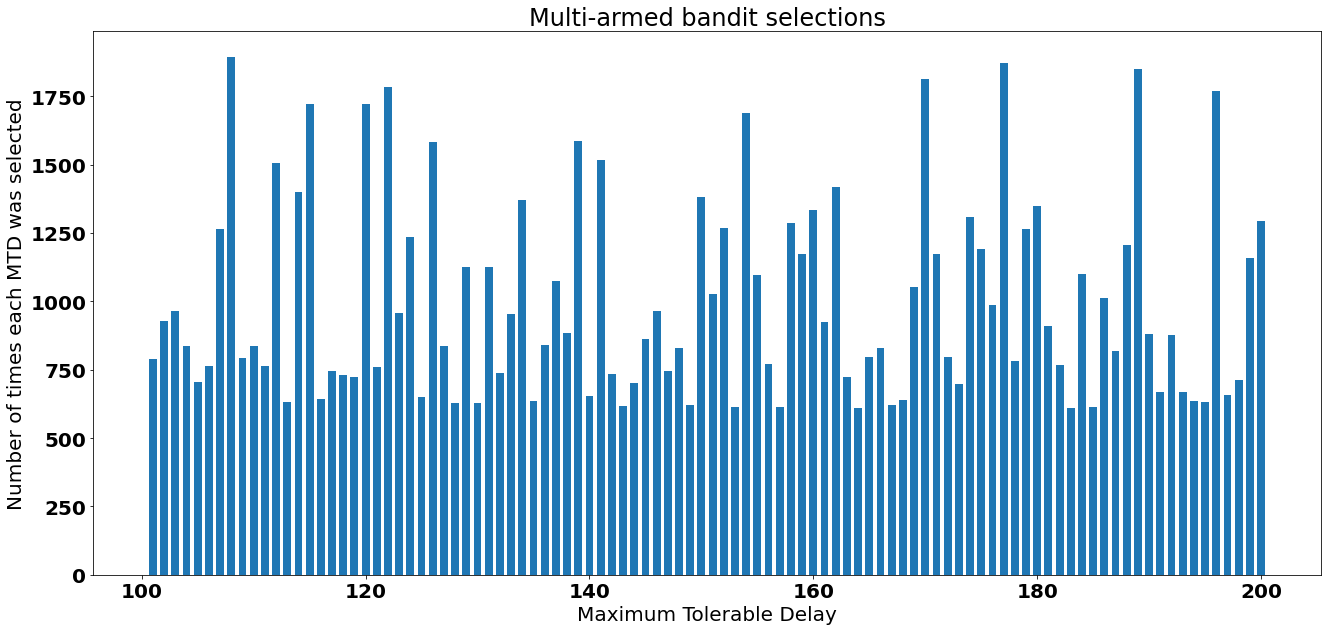

In [40]:
# change the font size on a matplotlib plot 
font = {'size' : 20} 
plt.rc('font', **font)
# change the graph size of a matplotlib plot 
plt.rcParams['figure.figsize'] = (22, 10)

# create a MTD id array 
MTD_id = np.array(range(1,MTD+1))
# create a selected MTD array
numbers_of_selections = np.asarray(numbers_of_selections)

# Visualising the results for UCB
plt.bar(delay[:,0]+100,numbers_of_selections,width=0.7)
plt.title('Multi-armed bandit selections')
plt.xlabel('Maximum Tolerable Delay')
plt.ylabel('Number of times each MTD was selected')
plt.show()

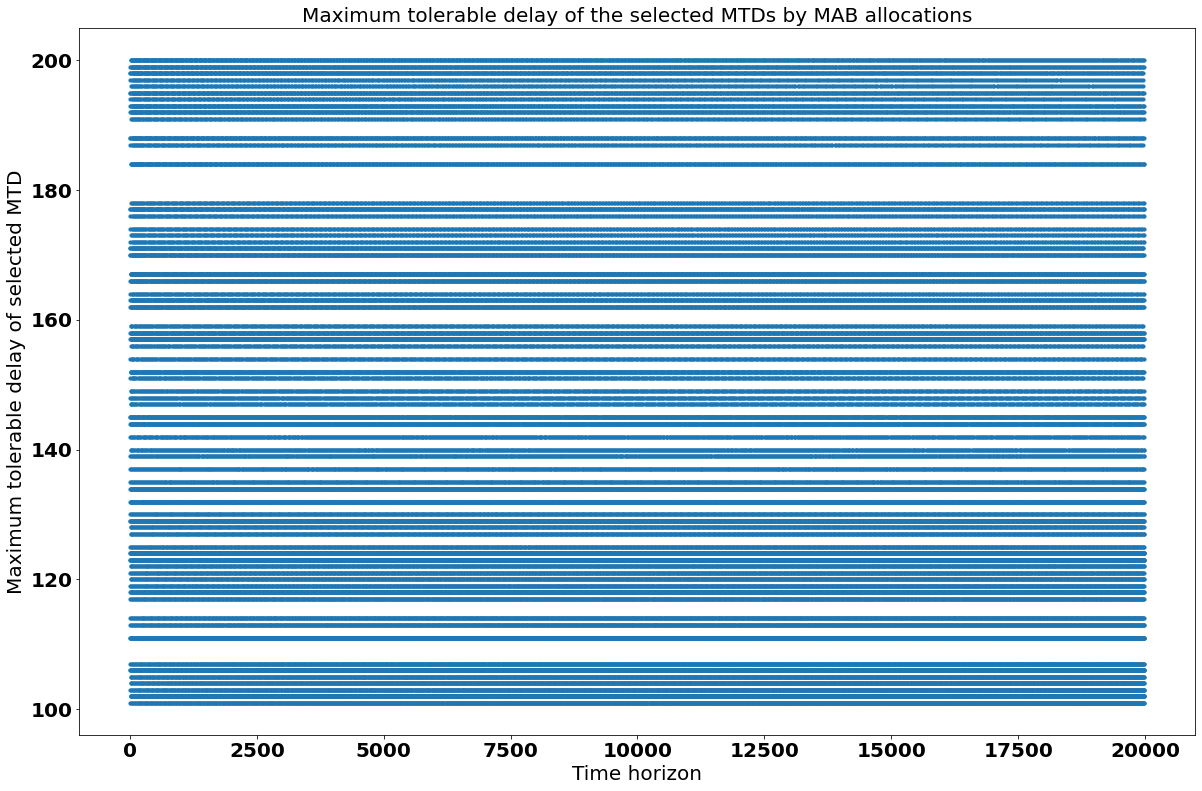

In [41]:
MTD_selected_UCB = np.asarray(MTD_selected_UCB)
MTD_selected_UCB = np.reshape(MTD_selected_UCB, (-1,1))
tolerable_delay_of_selected_mtd = np.asarray(tolerable_delay_of_selected_mtd)
tolerable_delay_of_selected_mtd = np.reshape(tolerable_delay_of_selected_mtd, (-1,1))

Time = np.array(range(0,TS))
Time = np.reshape(Time, (TS, 1))
#contTime = np.concatenate((Time, Time, Time, Time, Time,Time, Time, Time, 
#                           Time, Time,Time, Time, Time, Time, Time, Time, 
#                           Time, Time, Time, Time,Time), axis=1)
contTime = np.concatenate((Time, Time, Time, Time, Time), axis=1)
contTime = np.reshape(contTime, (-1,1))

delay_array = np.array(delay)

MTD_selected_UCB_X = delay_array[MTD_selected_UCB]
Maximum_Tolerable_Delay_of_selected_MTDs = [contTime,MTD_selected_UCB_X[:,:,1]]
Maximum_Tolerable_Delay_of_selected_MTDs = np.array(Maximum_Tolerable_Delay_of_selected_MTDs)
Maximum_Tolerable_Delay_of_selected_MTDs = Maximum_Tolerable_Delay_of_selected_MTDs.reshape(2,-1)
Maximum_Tolerable_Delay_of_selected_MTDs = pd.DataFrame(Maximum_Tolerable_Delay_of_selected_MTDs)
Maximum_Tolerable_Delay_of_selected_MTDs.to_csv('Maximum_Tolerable_Delay_of_selected_MTDs.csv', index=False)


# change the font siXe on a matplotlib plot 
font = {'family' : 'normal','weight' : 'bold','size' : 20} 
plt.rc('font', **font)
# change the graph siXe of a matplotlib plot 
plt.rcParams['figure.figsize'] = (20, 13)

# Visualising the maximum tolerable delay of the selected MTDs by algorithm over the time
plt.scatter(contTime,MTD_selected_UCB_X[:,:,1],s=10)
plt.title('Maximum tolerable delay of the selected MTDs by MAB allocations',fontsize=20)
plt.xlabel('Time horizon',fontsize=20)
plt.ylabel('Maximum tolerable delay of selected MTD',fontsize=20)
plt.show()

In [42]:
# Reshape the MTD_selected_UCB_X array
MTD_selected_UCB_X = np.reshape(MTD_selected_UCB_X[:,:,1], (TS*number_of_channels, ))
tolerable_delay_of_selected_mtd = np.reshape(tolerable_delay_of_selected_mtd, (TS*number_of_channels, ))


achieved_access_delay = MTD_selected_UCB_X - tolerable_delay_of_selected_mtd


MTD_selected_UCB_X = np.reshape(MTD_selected_UCB_X, (TS*number_of_channels, ))
tolerable_delay_of_selected_mtd = np.reshape(tolerable_delay_of_selected_mtd, (TS*number_of_channels, ))
achieved_access_delay = np.reshape(achieved_access_delay, (TS*number_of_channels, ))

delays_of_selected_MTDs = pd.DataFrame({'Maximum tolerable Delay':MTD_selected_UCB_X,'Tolerable Delay':tolerable_delay_of_selected_mtd, 'Achieved Access Delay':achieved_access_delay})


Maximum_Tolerbale_delay = delays_of_selected_MTDs.iloc[:,0].unique()
Maximum_Tolerbale_delay[::1].sort()

A = Maximum_Tolerbale_delay.tolist()
len(A)


average_achieved_delay_probabilitic_perfect = delays_of_selected_MTDs.groupby("Maximum tolerable Delay")['Achieved Access Delay'].describe()
average_achieved_delay_probabilitic_perfect = np.array(average_achieved_delay_probabilitic_perfect)
average_achieved_delay_probabilitic_perfect[:,1]

array([ 8.56735341,  8.88960516,  8.79878721,  9.10662177,  9.76088185,
        9.62202208,  9.81279621, 11.07828283, 11.21805007, 11.83111702,
       12.14396613, 12.30434783, 12.6214442 , 12.77579807, 13.30757689,
       13.44427481, 13.70182241, 13.79410216, 13.62540453, 14.41839271,
       14.7581864 , 14.98849595, 15.22644771, 15.78231897, 16.43214936,
       16.27069767, 17.        , 17.54580897, 17.73023715, 18.25430598,
       18.73015049, 19.19319372, 19.30387931, 20.11891892, 20.01538462,
       20.08813559, 20.63274588, 21.17169374, 21.16328963, 21.89039458,
       22.125     , 22.31013431, 23.11598746, 23.46902655, 23.55172414,
       24.09031839, 24.29226737, 25.13557047, 25.03598099, 25.20793434,
       25.08437068, 26.06094183, 26.59129213, 26.17709815, 26.56509299,
       27.7119403 , 28.3652968 , 28.49693721, 29.437014  , 29.11067504,
       29.75826772, 29.94136292, 30.11703822, 29.7266881 , 30.25645161,
       30.4136253 , 30.78519121, 30.5942623 ])

## Visualising the average achieved access delay from different allocation policies

In [53]:
X = np.array(range(1,20001))
Y = 5*X**1.00
Y = np.array(Y)

X1 = np.array(range(1,20001))
Y1 = 0.8*X1**1.15
Y1 = np.array(Y1)

X2 = np.array(range(1,20001))
Y2 = 0.4*X2**1.1
Y2 = np.array(Y2)

X3 = np.array(range(1,20001))
Y3 = 0.9*X3**1.155
Y3 = np.array(Y3)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


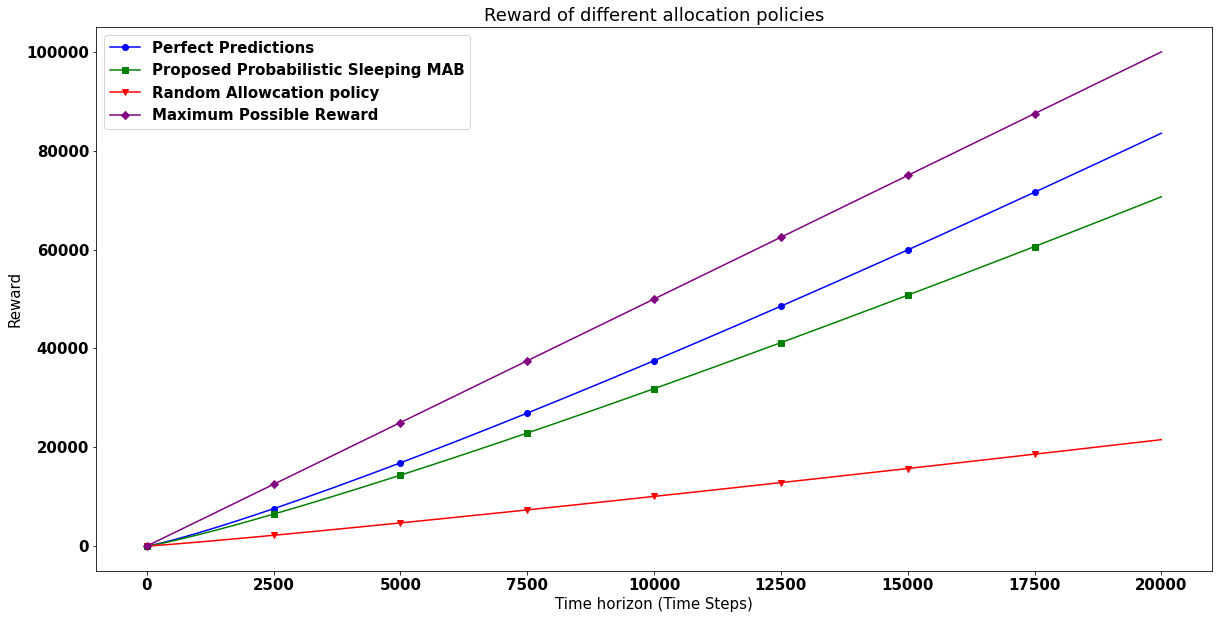

In [54]:
# change the font siXe on a matplotlib plot 
font = {'family' : 'normal','weight' : 'bold','size' : 15} 
plt.rc('font', **font)
# change the graph siXe of a matplotlib plot 
plt.rcParams['figure.figsize'] = (20, 10)

# Visualising the reward of different allocation policies
plt.plot(X3,Y3,label = 'Perfect Predictions',marker='o',markevery=2500,c='blue')
plt.plot(X1,Y1,label = 'Proposed Probabilistic Sleeping MAB',marker='s',markevery=2500,c='green')
plt.plot(X2,Y2,label = 'Random Allowcation policy',marker='v',markevery=2500,c='red')
plt.plot(X,Y,label = 'Maximum Possible Reward',marker='D',markevery=2500,c='purple')
plt.title('Reward of different allocation policies')
plt.xlabel('Time horizon (Time Steps)')
plt.ylabel('Reward')
plt.legend()
plt.show()

In [55]:
X4 = np.array(range(1,20001))
Y4 = 10*X4**0.9
Y4 = np.array(Y4)

X5 = np.array(range(1,20001))
Y5 = 24*X5**0.75
Y5 = np.array(Y5)

X6 = np.array(range(1,20001))
Y6 = 15*X6**0.75
Y6 = np.array(Y6)

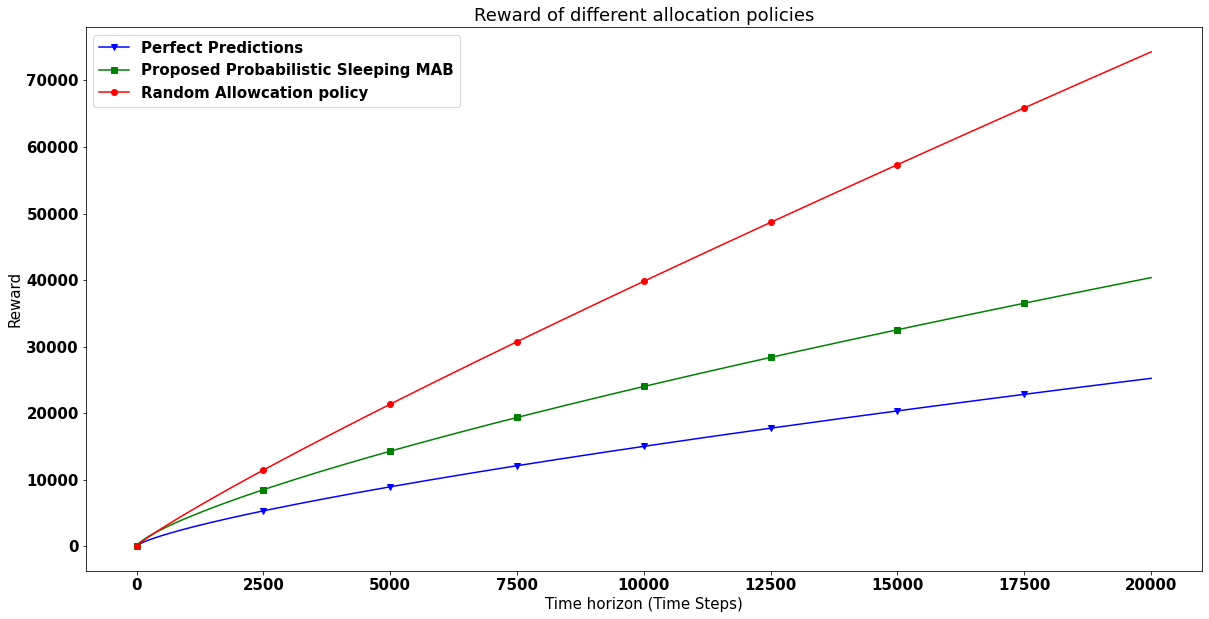

In [56]:
# change the font siXe on a matplotlib plot 
font = {'family' : 'normal','weight' : 'bold','size' : 15} 
plt.rc('font', **font)
# change the graph siXe of a matplotlib plot 
plt.rcParams['figure.figsize'] = (20, 10)

# Visualising the reward of different allocation policies
plt.plot(X6,Y6,label = 'Perfect Predictions',marker='v',markevery=2500, c='blue')
plt.plot(X5,Y5,label = 'Proposed Probabilistic Sleeping MAB',marker='s',markevery=2500,c='green')
plt.plot(X4,Y4,label = 'Random Allowcation policy',marker='o',markevery=2500,c= 'red')
plt.title('Reward of different allocation policies')
plt.xlabel('Time horizon (Time Steps)')
plt.ylabel('Reward')
plt.legend()
plt.show()

In [59]:
import random as rd

A = np.unique(delay[:,1])  
B = A*0.5
C = A*0.1
D = A*0.15

B = []
for i in range(0,64):
    Bi = A[i]*(rd.randrange(115,135)/100)-95
    B.append(Bi)

C = []
for i in range(0,64):
    Ci = A[i]*(rd.randrange(10,13)/100)
    C.append(Ci)

D = []
for i in range(0,64):
    Di = A[i]*(rd.randrange(50,54)/100)-34
    D.append(Di)

In [ ]:
# change the font siXe on a matplotlib plot 
font = {'family' : 'normal','weight' : 'bold','size' : 15} 
plt.rc('font', **font)
# change the graph siXe of a matplotlib plot 
plt.rcParams['figure.figsize'] = (20, 10)

# Visualising the reward of different allocation policies
plt.plot(A,B,label = 'Random Allowcation policy',marker='o',c= 'red')
plt.plot(A,C,label = 'Perfect Predictions',marker='v',c='blue')
plt.plot(A,D,label = 'Proposed Probabilistic Sleeping MAB',marker='s',c='green')
plt.title('Reward of different allocation policies')
plt.xlabel('Time horizon (Time Steps)')
plt.ylabel('Reward')
plt.legend()
plt.show()